In [2]:
from stocks import *
from util import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as pdr
import yfinance as yf
import random 

yf.pdr_override()

[*********************100%***********************]  5 of 5 completed


[*********************100%***********************]  5 of 5 completed


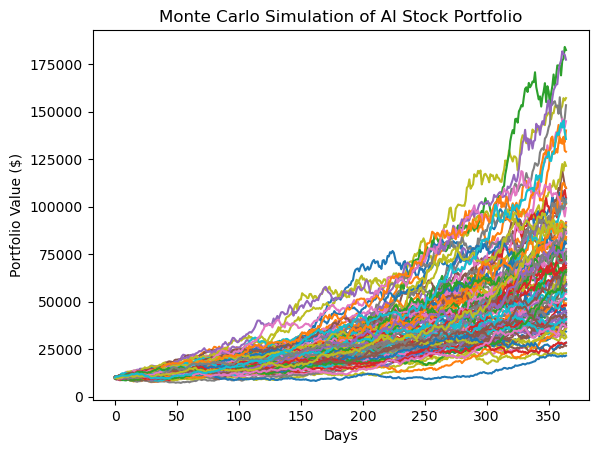

In [3]:
stockList = ['AI', 'GOOGL', 'META', 'AMD', 'NOW']
startDate = dt.datetime(2023, 1, 1)
endDate = dt.datetime.now()

meanReturns, covMatrix, stockData = getSummary(stockList, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo Simulation for regular AI stock equity portfolio 
sims = 100
T_days = 365 

meanMatrix = np.full(shape=(T_days, len(weights)), fill_value=meanReturns)
meanMatrix = meanMatrix.T

portfolio_sims = np.full(shape=(T_days, sims), fill_value=0.0)
starting_balance = 10000

for m in range(0, sims):
    Z = np.random.normal(size=(T_days, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanMatrix + np.inner(L, Z)
    portfolio_sims[:,m] = starting_balance*np.cumprod(np.inner(weights, dailyReturns.T)+1)

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Monte Carlo Simulation of AI Stock Portfolio')
plt.show()

In [4]:
portfolio_end = pd.Series(portfolio_sims[-1,:])

VaR = starting_balance - getVaR(portfolio_end, alpha=5)
CVaR = starting_balance - getCVaR(portfolio_end, alpha=5)

print('VaR: ${}'.format(round(VaR,2)))
print('CVaR: ${}'.format(round(CVaR,2)))

VaR: $-21036.43
CVaR: $-15628.41


In [5]:
logReturns = np.diff(np.log(portfolio_sims), axis=0)
dailySTD = logReturns.std()
annualizedSTD = dailySTD * np.sqrt(252)

initial_value = starting_balance
final_value = portfolio_sims[-1]
cumReturns = (final_value - initial_value) / initial_value
cumReturns = cumReturns.mean()

sharpeRatio = (cumReturns - 0.05)/annualizedSTD

print('Sharpe Ratio: {}'.format(round(sharpeRatio, 2)))

Sharpe Ratio: 15.46


In [6]:
logReturns2 = logReturns[logReturns<0]
dailySTD2 = logReturns2.std()
annualizedSTD2 = dailySTD2 * np.sqrt(252)
annualizedSTD2


sortinoRatio = (cumReturns - 0.05)/annualizedSTD2
print('Sortino Ratio: {}'.format(round(sortinoRatio, 2)))

Sortino Ratio: 26.71


##### Sortino Ratio consistently around 1.7x of Sharpe Ratio --> indicates portfolio's strong likelihood of large positive returns

In [7]:
df = options_data("GOOGL")
df

,contractSymbol,strike,bid,ask,impliedVolatility,expirationDate,DTE,Call,Mark Price
0,GOOGL230630C00050000,50.0,68.65,68.80,3.988281,2023-07-01,0.008219,True,68.725
1,GOOGL230630C00060000,60.0,58.60,58.75,3.093752,2023-07-01,0.008219,True,58.675
2,GOOGL230630C00065000,65.0,52.45,54.05,3.361330,2023-07-01,0.008219,True,53.250
3,GOOGL230630C00070000,70.0,48.20,48.90,2.070317,2023-07-01,0.008219,True,48.550
4,GOOGL230630C00075000,75.0,43.60,43.80,2.214848,2023-07-01,0.008219,True,43.700
...,...,...,...,...,...,...,...,...,...
2242,GOOGL251219P00165000,165.0,45.45,49.40,0.192391,2025-12-20,2.482192,False,47.425
2243,GOOGL251219P00175000,175.0,54.20,57.25,0.153817,2025-12-20,2.482192,False,55.725
2244,GOOGL251219P00180000,180.0,70.15,73.95,0.383704,2025-12-20,2.482192,False,72.050
2245,GOOGL251219P00185000,185.0,79.00,84.00,0.466405,2025-12-20,2.482192,False,81.500


In [8]:
# Using one stock (GOOGL) for now (CALLS)
# TODO: Expand to multiple stocks to make an options portfolio

G_calls = df[df['Call'] == True]


randCall = np.random.randint(2, len(G_calls)-2)
sigma = G_calls.iloc[randCall]['impliedVolatility']

initRow = G_calls.iloc[randCall + 1]

T = initRow['DTE']
K = initRow['strike']
S_init = get_latest_price("GOOGL")
r = 0.05
N = 100
mark = G_calls.iloc[randCall]['Mark Price']

print(binomial_tree_compounded_CRR(T, K, S_init, r, N, sigma, type="C"))
print(binomial_tree_compounded_JR(T, K, S_init, r, N, sigma, type="C"))
print(blackScholes(S_init, K, r, sigma, T, type="C"))

[*********************100%***********************]  1 of 1 completed
69.13306400448239
69.02181195769083
69.07838331684746


In [9]:
# Monte Carlo Sim --> utilizing binomial tree in natural logarithmic terms (CALLS)

M = 10000

dt = T/N
nudt = (r - 0.5*sigma**2)*dt
voldt = sigma*np.sqrt(dt)
lnS = np.log(S_init)

sum_C = 0
sum_C_squared = 0

for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + voldt*np.random.normal()
    
    ST = np.exp(lnSt)
    C = max(0, ST - K)
    sum_C = sum_C + C
    sum_C_squared = sum_C_squared + C*C

C0 = np.exp(-r*T)*sum_C/M
sigmaGBM = np.sqrt((sum_C_squared - sum_C*sum_C/M)*np.exp(-2*r*T)/(M-1))
SE = sigmaGBM/np.sqrt(M)

print("Call value is ${0} with an SE of +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $66.25 with an SE of +/- 1.43


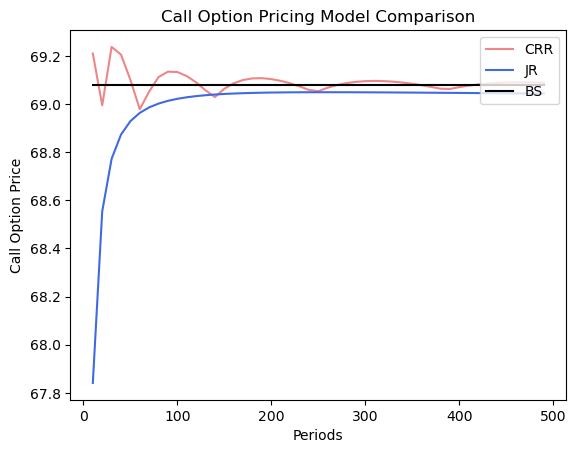

In [10]:
CRR, JR, BS = [],[],[]
timePeriods = range(10, 500, 10)

for N in timePeriods:
    CRR.append(binomial_tree_compounded_CRR(T, K, S_init, r, N, sigma, type="C"))
    JR.append(binomial_tree_compounded_JR(T, K, S_init, r, N, sigma, type="C"))
    BS.append(blackScholes(S_init, K, r, sigma, T, type="C"))

plt.plot(timePeriods, CRR, label='CRR', color='#ed8689')
plt.plot(timePeriods, JR, label='JR', color='#4169e1')
plt.plot(timePeriods, BS, label='BS', color='black')
plt.ylabel("Call Option Price")
plt.xlabel("Periods")
plt.legend(loc='upper right')
plt.title('Call Option Pricing Model Comparison')
plt.show()


In [11]:
# Using one stock (GOOGL) for now (PUTS)
# TODO: Expand to multiple stocks to make an options portfolio

G_puts = df[df['Call'] == False]

randPut = np.random.randint(2, len(G_puts)-2)
sigma2 = G_puts.iloc[randPut]['impliedVolatility']

initRow2 = G_puts.iloc[randPut + 1]

T = initRow2['DTE']
K = initRow2['strike']
S_init = get_latest_price("GOOGL")
r = 0.05
N = 100
mark = G_puts.iloc[randPut]['Mark Price']

print(binomial_tree_compounded_CRR(T, K, S_init, r, N, sigma2, type="P"))
print(binomial_tree_compounded_JR(T, K, S_init, r, N, sigma2, type="P"))
print(blackScholes(S_init, K, r, sigma2, T, type="P"))

[*********************100%***********************]  1 of 1 completed
1.9316865029871182
1.918297304210957
1.8761545698853634


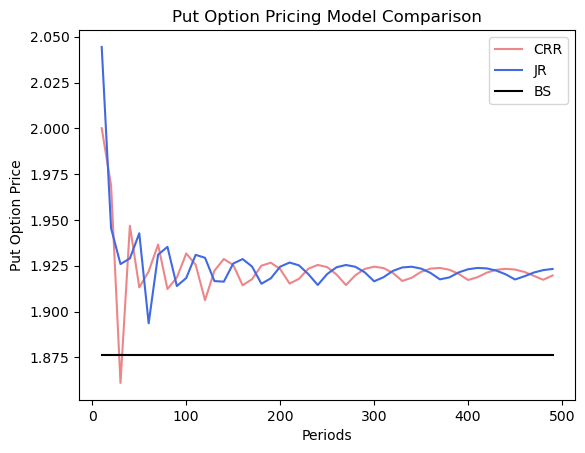

In [12]:
CRR, JR, BS = [],[],[]
timePeriods = range(10, 500, 10)

for N in timePeriods:
    CRR.append(binomial_tree_compounded_CRR(T, K, S_init, r, N, sigma2, type="P"))
    JR.append(binomial_tree_compounded_JR(T, K, S_init, r, N, sigma2, type="P"))
    BS.append(blackScholes(S_init, K, r, sigma2, T, type="P"))

plt.plot(timePeriods, CRR, label='CRR', color='#ed8689')
plt.plot(timePeriods, JR, label='JR', color='#4169e1')
plt.plot(timePeriods, BS, label='BS', color='black')
plt.ylabel("Put Option Price")
plt.xlabel("Periods")
plt.legend(loc='upper right')
plt.title('Put Option Pricing Model Comparison')
plt.show()

In [16]:
dfSP = options_data("GOOGL")

unique_dates = dfSP['expirationDate'].unique()
random_date = random.choice(unique_dates)

optionsWithDate = dfSP[dfSP['expirationDate'] == random_date]
callsWithDate = optionsWithDate[optionsWithDate['Call'] == True]
putsWithDate = optionsWithDate[optionsWithDate['Call'] == False]

merged_options = pd.merge(callsWithDate, putsWithDate, on='strike', suffixes=('(C)', '(P)'))
merged_options

,contractSymbol(C),strike,bid(C),ask(C),impliedVolatility(C),expirationDate(C),DTE(C),Call(C),Mark Price(C),contractSymbol(P),bid(P),ask(P),impliedVolatility(P),expirationDate(P),DTE(P),Call(P),Mark Price(P)
0,GOOGL230818C00040000,40.0,78.85,79.45,1.591799,2023-08-19,0.142466,True,79.150,GOOGL230818P00040000,0.00,0.02,0.953125,2023-08-19,0.142466,False,0.010
1,GOOGL230818C00045000,45.0,74.00,74.45,1.464846,2023-08-19,0.142466,True,74.225,GOOGL230818P00045000,0.00,0.11,1.015630,2023-08-19,0.142466,False,0.055
2,GOOGL230818C00050000,50.0,68.80,69.35,1.257816,2023-08-19,0.142466,True,69.075,GOOGL230818P00050000,0.00,0.01,0.718753,2023-08-19,0.142466,False,0.005
3,GOOGL230818C00055000,55.0,66.55,69.30,1.932129,2023-08-19,0.142466,True,67.925,GOOGL230818P00055000,0.00,0.01,0.656253,2023-08-19,0.142466,False,0.005
4,GOOGL230818C00060000,60.0,60.50,64.55,1.696779,2023-08-19,0.142466,True,62.525,GOOGL230818P00060000,0.00,0.02,0.609379,2023-08-19,0.142466,False,0.010
5,GOOGL230818C00065000,65.0,54.15,54.45,0.980957,2023-08-19,0.142466,True,54.300,GOOGL230818P00065000,0.01,0.02,0.562504,2023-08-19,0.142466,False,0.015
6,GOOGL230818C00070000,70.0,48.80,49.30,0.806154,2023-08-19,0.142466,True,49.050,GOOGL230818P00070000,0.02,0.03,0.527348,2023-08-19,0.142466,False,0.025
7,GOOGL230818C00075000,75.0,44.05,44.35,0.755374,2023-08-19,0.142466,True,44.200,GOOGL230818P00075000,0.04,0.05,0.501958,2023-08-19,0.142466,False,0.045
8,GOOGL230818C00080000,80.0,39.20,39.80,0.726809,2023-08-19,0.142466,True,39.500,GOOGL230818P00080000,0.06,0.07,0.457037,2023-08-19,0.142466,False,0.065
9,GOOGL230818C00085000,85.0,34.40,34.50,0.626957,2023-08-19,0.142466,True,34.450,GOOGL230818P00085000,0.10,0.11,0.419928,2023-08-19,0.142466,False,0.105


In [19]:
randLine = np.random.randint(2, len(merged_options)-2)
sigmaLS_C = merged_options.iloc[randLine]['impliedVolatility(C)']
sigmaLS_P = merged_options.iloc[randLine]['impliedVolatility(P)']


initRowLS = merged_options.iloc[randLine + 1]

print("We are using line: {}".format(randLine+1))

T = initRowLS['DTE(C)']
K = initRowLS['strike']
S_init = get_latest_price("GOOGL")
r = 0.05
N = 100
mark_C = merged_options.iloc[randLine]['Mark Price(C)']
mark_P = merged_options.iloc[randLine]['Mark Price(P)']


print(binomial_tree_compounded_CRR(T, K, S_init, r, N, sigmaLS_C, type="C"))
print(binomial_tree_compounded_CRR(T, K, S_init, r, N, sigmaLS_P, type="P"))

We are using line: 15
[*********************100%***********************]  1 of 1 completed
8.65123678806796
3.3362202914400494


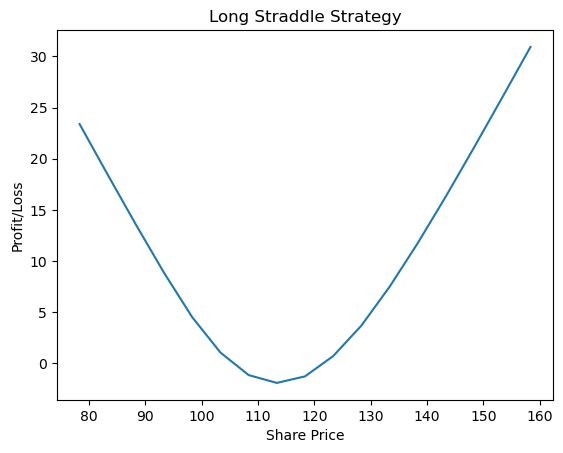

In [20]:
share_prices = np.arange(S_init-40, S_init + 41, 5)
call_vals = []
put_vals = []
profits = []
premium = mark_C + mark_P

for price in share_prices:
    call_value = binomial_tree_compounded_CRR(T, K, price, r, N, sigmaLS_C, type="C")
    call_vals.append(call_value)

    put_value = binomial_tree_compounded_CRR(T, K, price, r, N, sigmaLS_P, type="P")
    put_vals.append(put_value)

    profit = call_value + put_value - premium
    profits.append(profit)

plt.plot(share_prices, profits)
plt.xlabel("Share Price")
plt.ylabel("Profit/Loss")
plt.title("Long Straddle Strategy")
plt.show()